In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv("base_proyecto_2.csv", sep = ",", index_col=0)
df

,pobreza_binaria,pobreza,ingresos,edad
index,,,,
1,No pobreza,No pobreza,42000,34
2,No pobreza,No pobreza,40000,67
3,No pobreza,No pobreza,31000,47
4,No pobreza,No pobreza,30000,69
5,No pobreza,No pobreza,30000,40
...,...,...,...,...
9446,Pobreza,Pobreza no extrema,30,19
9447,No pobreza,No pobreza,25,21
9448,No pobreza,No pobreza,25,22


C:\Users\IN_CAP02\AppData\Local\Temp\ipykernel_13244\1717204593.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Pobreza" )


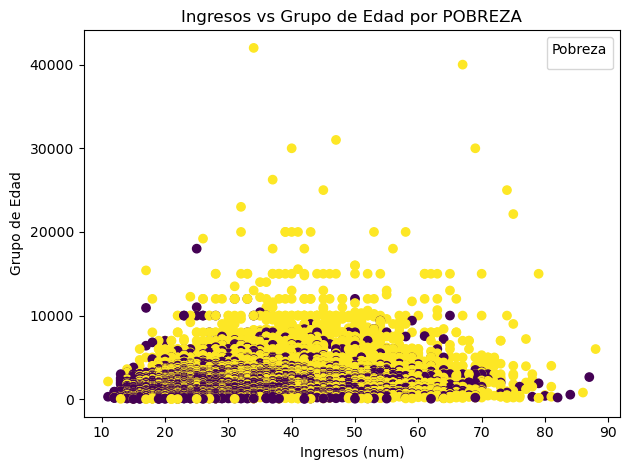

In [71]:
plt.scatter(
    df["edad" ],
    df["ingresos" ],
    c=df["pobreza_binaria"])


plt.xlabel("Ingresos (num)")
plt.ylabel("Grupo de Edad")
plt.title("Ingresos vs Grupo de Edad por POBREZA")
plt.legend(title="Pobreza" )
plt.tight_layout()
plt.show()

In [76]:
# Re-plot with X=Ingresos (parsed to numeric), Y=Grupo de Edad, Hue=POBREZA
df0 = df.copy()

# --- Parse "Ingresos" to numeric robustly ---


df0["Ingresos_num"] = parse_ingresos(df0["Ingresos"])

# Prepare data
required_cols = ["Grupo de Edad", "POBREZA", "Ingresos_num"]
plot_df = df0[required_cols].dropna()

# Cast hue to categorical for clearer legend labels
plot_df["POBREZA"] = plot_df["POBREZA"].astype(int)

# Plot
plt.figure(figsize=(9, 6))
for k, g in plot_df.groupby("POBREZA"):
    plt.scatter(g["Ingresos_num"], g["Grupo de Edad"], label=str(k), alpha=0.8, s=20)



# Quick report on parsing success
report = pd.DataFrame({
    "rows_total":[len(df0)],
    "parsed_non_na":[plot_df.shape[0]],
    "dropped_rows":[len(df0) - plot_df.shape[0]]
})

KeyError: 'Ingresos'

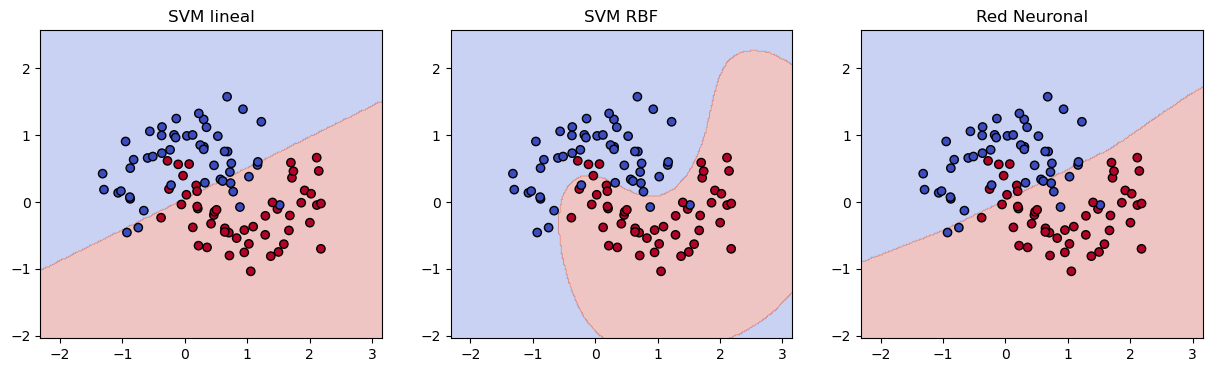

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# 1. Dataset
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Modelos supervisados
models = {
    "SVM lineal": SVC(kernel="linear", C=1),
    "SVM RBF": SVC(kernel="rbf", gamma=0.7, C=1),
    "Red Neuronal": MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=1)
}

# 3. Ajustar modelos
for name, clf in models.items():
    clf.fit(X_train, y_train)

# 4. Función para graficar la frontera de decisión
def plot_decision_boundary(ax, clf, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="k")
    ax.set_title(title)

# 5. Graficar resultados
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, clf) in zip(axs, models.items()):
    plot_decision_boundary(ax, clf, X, y, name)

plt.show()

In [80]:
X_train.size, y_train.size

(140, 70)